In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

device = torch.device('cpu')


In [2]:
# Define the exact solution
def exact_solution_u(x, t):
    return (2.5*pi*torch.cos(x)+(x-pi*2.5))*torch.cos(t)

def initial_condition_u(x):
    return 2.5*pi*torch.cos(x) + (x - pi*2.5)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x)

# Define the exact solution
def exact_solution_p(x, t):
    return 2.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 2.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x)

# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

eps = 5
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = 6*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1).to(device)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1).to(device)
w_init = torch.cat([u_init, p_init],1).to(device)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1).to(device)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1).to(device)
w_t_init = torch.cat([u_t_init, p_t_init],1).to(device)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = exact_solution_u(xb_left, tb_left).to(device)
p_b_l = exact_solution_p(xb_left, tb_left).to(device)
w_b_l = torch.cat([u_b_l, p_b_l],1).to(device)



xb_right = 6*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = exact_solution_u(xb_right, tb_right).to(device)
p_b_r = exact_solution_p(xb_right, tb_right).to(device)
w_b_r = torch.cat([u_b_r, p_b_r],1).to(device)

# x_interior = pi*torch.rand((residual_pts, 1))
# t_interior = torch.rand((residual_pts, 1))
# interior = torch.cat([x_interior, t_interior],1)

x_int = torch.linspace(0, 6*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 1, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero




training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), w_init.to(device), w_t_init.to(device), b_left.to(device),  b_right.to(device)), batch_size=2000, shuffle=False)


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

In [4]:
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 2, n_hidden_layers=4, neurons=200)
model_state_dict = torch.load('causal_timo.pth', map_location=torch.device('cpu'))
my_network = my_network.to(device)

# after defining my network - also dont forget to comment xavier
my_network.load_state_dict(model_state_dict)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left, bd_right) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:, 0].reshape(-1, 1)
                p_initial_pred_ = w_initial_pred_[:, 1].reshape(-1, 1)

                # with derivative
                inpu = torch.ones(initial_pts, 1).to(device)

                grad_u_ini = \
                torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[
                    0]

                u_initial_t = grad_u_ini[:, 1]

                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]

                p_initial_t = grad_p_ini[:, 1]

                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:, 0].reshape(-1, 1)
                p_bd_left_pred_ = w_bd_left_pred_[:, 1].reshape(-1, 1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:, 0].reshape(-1, 1)
                p_bd_right_pred_ = w_bd_right_pred_[:, 1].reshape(-1, 1)

                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:, 0].reshape(-1, 1)
                p_hat = w_hat[:, 1].reshape(-1, 1)
                inputs = torch.ones(residual_pts, 1).to(device)
                inputs2 = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = \
                torch.autograd.grad(u_hat.reshape(-1, 1), interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, 1)

                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]

                u_xx = grad_u_hat_xx[:, 0].reshape(-1, 1)

                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                p_x = grad_p_hat[:, 0].reshape(-1, 1)

                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]

                p_xx = grad_p_hat_xx[:, 0].reshape(-1, 1)

                # grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                # u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1, 1)

                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]

                u_tt = grad_u_hat_tt[:, 1].reshape(-1, 1)

                p_t = grad_p_hat[:, 1].reshape(-1, 1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]

                p_tt = grad_p_hat_tt[:, 1].reshape(-1, 1)

                pde_single_column = (u_tt.reshape(-1, ) - u_xx.reshape(-1, ) + u_hat.reshape(-1, ) - p_x.reshape(
                    -1, )) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                pde_single_column1 = (p_tt.reshape(-1, ) + u_x.reshape(-1, ) - p_xx.reshape(-1, ) + p_hat.reshape(
                    -1, ) - torch.cos(interior[:, 1]).reshape(-1, )) ** 2
                pde_single_column1 = pde_single_column1.reshape(-1, 1)

                pde_matrix1 = pde_single_column1.reshape(100, 100)

                loss_at_time_steps1 = torch.mean(pde_matrix1, 1)
                loss_at_time_steps1 = loss_at_time_steps1.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss1 = torch.matmul(W, loss_at_time_steps1)
                weighted_loss1 = torch.exp(-eps * weighted_loss1)

                loss_pde1 = torch.mean(weighted_loss1 * loss_at_time_steps1)

                # Item 1. below
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, )) ** p) + torch.mean(
                    (u_initial_pred_.reshape(-1, ) - w_initial[:, 0].reshape(-1, )) ** p) + loss_pde + torch.mean(
                    (u_bd_left_pred_.reshape(-1, ) - u_b_l.reshape(-1, )) ** p) + torch.mean(
                    (u_bd_right_pred_.reshape(-1, ) - u_b_r.reshape(-1, )) ** p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:, 1].reshape(-1, )) ** p) + torch.mean(
                    (p_initial_t.reshape(-1, ) - w_initial_t[:, 1].reshape(-1, )) ** p) + loss_pde1 + torch.mean(
                    (p_bd_left_pred_.reshape(-1, ) - p_b_l.reshape(-1, )) ** p) + torch.mean(
                    (p_bd_right_pred_.reshape(-1, ) - p_b_r.reshape(-1, )) ** p)
                loss = loss1 + loss2
                # loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history



In [5]:
start_time = time.time()
n_epochs = 3000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

end_time = time.time()
total_time = end_time - start_time
print("total_time", total_time)

with open('p9_6pi_5k.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'p9_6pi_5k.pth')

################################  0  ################################
Loss:  167.48880004882812
################################  1  ################################
Loss:  167.1192626953125
################################  2  ################################
Loss:  148.86337280273438
################################  3  ################################
Loss:  125.98804473876953
################################  4  ################################
Loss:  107.95648956298828
################################  5  ################################
Loss:  98.22955322265625
################################  6  ################################
Loss:  91.2973403930664
################################  7  ################################
Loss:  85.35773468017578
################################  8  ################################
Loss:  80.16271209716797
################################  9  ################################
Loss:  75.61641693115234
################################  10  #########

Loss:  19.46875
################################  86  ################################
Loss:  19.1519775390625
################################  87  ################################
Loss:  18.877361297607422
################################  88  ################################
Loss:  18.57779312133789
################################  89  ################################
Loss:  18.315452575683594
################################  90  ################################
Loss:  18.029773712158203
################################  91  ################################
Loss:  17.776447296142578
################################  92  ################################
Loss:  17.50086784362793
################################  93  ################################
Loss:  17.253665924072266
################################  94  ################################
Loss:  16.98534393310547
################################  95  ################################
Loss:  16.742645263671875
###################

Loss:  4.996085166931152
################################  171  ################################
Loss:  4.911658763885498
################################  172  ################################
Loss:  4.833654880523682
################################  173  ################################
Loss:  4.751920700073242
################################  174  ################################
Loss:  4.677604675292969
################################  175  ################################
Loss:  4.600109577178955
################################  176  ################################
Loss:  4.5286865234375
################################  177  ################################
Loss:  4.454277038574219
################################  178  ################################
Loss:  4.386061668395996
################################  179  ################################
Loss:  4.316138744354248
################################  180  ################################
Loss:  4.252945423126221
#######

Loss:  1.9777512550354004
################################  256  ################################
Loss:  1.9567947387695312
################################  257  ################################
Loss:  1.9352822303771973
################################  258  ################################
Loss:  1.9137787818908691
################################  259  ################################
Loss:  1.8915317058563232
################################  260  ################################
Loss:  1.8692498207092285
################################  261  ################################
Loss:  1.8461031913757324
################################  262  ################################
Loss:  1.8230046033859253
################################  263  ################################
Loss:  1.798949122428894
################################  264  ################################
Loss:  1.775097370147705
################################  265  ################################
Loss:  1.7502140998840

Loss:  0.36990097165107727
################################  340  ################################
Loss:  0.36396878957748413
################################  341  ################################
Loss:  0.3579116463661194
################################  342  ################################
Loss:  0.3512355089187622
################################  343  ################################
Loss:  0.344692587852478
################################  344  ################################
Loss:  0.33873945474624634
################################  345  ################################
Loss:  0.33266696333885193
################################  346  ################################
Loss:  0.3264034390449524
################################  347  ################################
Loss:  0.3200400471687317
################################  348  ################################
Loss:  0.31402313709259033
################################  349  ################################
Loss:  0.3083644

Loss:  0.11174176633358002
################################  424  ################################
Loss:  0.11057711392641068
################################  425  ################################
Loss:  0.1094474196434021
################################  426  ################################
Loss:  0.10831978917121887
################################  427  ################################
Loss:  0.10723564028739929
################################  428  ################################
Loss:  0.10615982115268707
################################  429  ################################
Loss:  0.10513414442539215
################################  430  ################################
Loss:  0.10412146151065826
################################  431  ################################
Loss:  0.10316012799739838
################################  432  ################################
Loss:  0.1022149920463562
################################  433  ################################
Loss:  0.101

Loss:  0.04433302581310272
################################  507  ################################
Loss:  0.04403957724571228
################################  508  ################################
Loss:  0.04363929480314255
################################  509  ################################
Loss:  0.0433477908372879
################################  510  ################################
Loss:  0.04296998307108879
################################  511  ################################
Loss:  0.042676784098148346
################################  512  ################################
Loss:  0.042363010346889496
################################  513  ################################
Loss:  0.04199269413948059
################################  514  ################################
Loss:  0.04160325974225998
################################  515  ################################
Loss:  0.041243284940719604
################################  516  ################################
Loss:  0

Loss:  0.024720411747694016
################################  590  ################################
Loss:  0.02450873702764511
################################  591  ################################
Loss:  0.024312831461429596
################################  592  ################################
Loss:  0.024129681289196014
################################  593  ################################
Loss:  0.02395842969417572
################################  594  ################################
Loss:  0.02379625104367733
################################  595  ################################
Loss:  0.023647915571928024
################################  596  ################################
Loss:  0.023515623062849045
################################  597  ################################
Loss:  0.02339659444987774
################################  598  ################################
Loss:  0.023282084614038467
################################  599  ################################
Loss

Loss:  0.015299750491976738
################################  673  ################################
Loss:  0.015232997015118599
################################  674  ################################
Loss:  0.015162812545895576
################################  675  ################################
Loss:  0.01509346254169941
################################  676  ################################
Loss:  0.015016494318842888
################################  677  ################################
Loss:  0.014947472140192986
################################  678  ################################
Loss:  0.014857534319162369
################################  679  ################################
Loss:  0.014796530827879906
################################  680  ################################
Loss:  0.014731060713529587
################################  681  ################################
Loss:  0.01466228999197483
################################  682  ################################
Lo

Loss:  0.010781120508909225
################################  756  ################################
Loss:  0.010759593918919563
################################  757  ################################
Loss:  0.010736774653196335
################################  758  ################################
Loss:  0.010715405456721783
################################  759  ################################
Loss:  0.010692963376641273
################################  760  ################################
Loss:  0.010671894066035748
################################  761  ################################
Loss:  0.010649755597114563
################################  762  ################################
Loss:  0.010628901422023773
################################  763  ################################
Loss:  0.010607222095131874
################################  764  ################################
Loss:  0.01058649830520153
################################  765  ################################
L

Loss:  0.009134987369179726
################################  839  ################################
Loss:  0.009131887927651405
################################  840  ################################
Loss:  0.009126802906394005
################################  841  ################################
Loss:  0.009124107658863068
################################  842  ################################
Loss:  0.009119592607021332
################################  843  ################################
Loss:  0.00911702774465084
################################  844  ################################
Loss:  0.009112538769841194
################################  845  ################################
Loss:  0.009109334088861942
################################  846  ################################
Loss:  0.009103790856897831
################################  847  ################################
Loss:  0.00909951888024807
################################  848  ################################
Lo

Loss:  0.007992547005414963
################################  922  ################################
Loss:  0.007977345958352089
################################  923  ################################
Loss:  0.007962347939610481
################################  924  ################################
Loss:  0.007948067039251328
################################  925  ################################
Loss:  0.007935719564557076
################################  926  ################################
Loss:  0.007922420278191566
################################  927  ################################
Loss:  0.007908741943538189
################################  928  ################################
Loss:  0.007893803529441357
################################  929  ################################
Loss:  0.007881425321102142
################################  930  ################################
Loss:  0.007868423126637936
################################  931  ################################


Loss:  0.0072663165628910065
################################  1004  ################################
Loss:  0.0072567155584692955
################################  1005  ################################
Loss:  0.007244597189128399
################################  1006  ################################
Loss:  0.007228628732264042
################################  1007  ################################
Loss:  0.007213236764073372
################################  1008  ################################
Loss:  0.00719809252768755
################################  1009  ################################
Loss:  0.007183242589235306
################################  1010  ################################
Loss:  0.007170515134930611
################################  1011  ################################
Loss:  0.007158453576266766
################################  1012  ################################
Loss:  0.007149009965360165
################################  1013  ######################

Loss:  0.0066458676010370255
################################  1086  ################################
Loss:  0.006642192602157593
################################  1087  ################################
Loss:  0.006643986329436302
################################  1088  ################################
Loss:  0.006640058010816574
################################  1089  ################################
Loss:  0.006636091507971287
################################  1090  ################################
Loss:  0.006630050949752331
################################  1091  ################################
Loss:  0.006620519794523716
################################  1092  ################################
Loss:  0.006608197465538979
################################  1093  ################################
Loss:  0.006594566628336906
################################  1094  ################################
Loss:  0.006578473374247551
################################  1095  ######################

Loss:  0.006187081336975098
################################  1168  ################################
Loss:  0.006181416101753712
################################  1169  ################################
Loss:  0.006177965551614761
################################  1170  ################################
Loss:  0.00617449264973402
################################  1171  ################################
Loss:  0.006172040477395058
################################  1172  ################################
Loss:  0.006168454885482788
################################  1173  ################################
Loss:  0.006173288449645042
################################  1174  ################################
Loss:  0.006172269582748413
################################  1175  ################################
Loss:  0.0061737727373838425
################################  1176  ################################
Loss:  0.006175054702907801
################################  1177  #######################

Loss:  0.006348516792058945
################################  1250  ################################
Loss:  0.006350371986627579
################################  1251  ################################
Loss:  0.006348822265863419
################################  1252  ################################
Loss:  0.006351638585329056
################################  1253  ################################
Loss:  0.006350040901452303
################################  1254  ################################
Loss:  0.00635297317057848
################################  1255  ################################
Loss:  0.006352861411869526
################################  1256  ################################
Loss:  0.006352669559419155
################################  1257  ################################
Loss:  0.0063527775928378105
################################  1258  ################################
Loss:  0.006351647432893515
################################  1259  #######################

Loss:  0.006241414695978165
################################  1331  ################################
Loss:  0.006234367378056049
################################  1332  ################################
Loss:  0.00622908677905798
################################  1333  ################################
Loss:  0.006222194992005825
################################  1334  ################################
Loss:  0.006217147223651409
################################  1335  ################################
Loss:  0.006210110615938902
################################  1336  ################################
Loss:  0.006205166224390268
################################  1337  ################################
Loss:  0.0061979228630661964
################################  1338  ################################
Loss:  0.006193283013999462
################################  1339  ################################
Loss:  0.0061865197494626045
################################  1340  ######################

Loss:  0.005840415135025978
################################  1413  ################################
Loss:  0.005841689184308052
################################  1414  ################################
Loss:  0.005841484293341637
################################  1415  ################################
Loss:  0.005843350663781166
################################  1416  ################################
Loss:  0.005844102241098881
################################  1417  ################################
Loss:  0.005846988409757614
################################  1418  ################################
Loss:  0.005846280138939619
################################  1419  ################################
Loss:  0.005850400775671005
################################  1420  ################################
Loss:  0.005848285276442766
################################  1421  ################################
Loss:  0.005848463624715805
################################  1422  #######################

Loss:  0.005563048645853996
################################  1495  ################################
Loss:  0.005559157580137253
################################  1496  ################################
Loss:  0.005555324722081423
################################  1497  ################################
Loss:  0.005552276037633419
################################  1498  ################################
Loss:  0.005549467168748379
################################  1499  ################################
Loss:  0.00554721150547266
################################  1500  ################################
Loss:  0.005545411258935928
################################  1501  ################################
Loss:  0.005544065497815609
################################  1502  ################################
Loss:  0.005543326493352652
################################  1503  ################################
Loss:  0.005542558152228594
################################  1504  ########################

Loss:  0.005358614958822727
################################  1577  ################################
Loss:  0.005355157423764467
################################  1578  ################################
Loss:  0.005352926440536976
################################  1579  ################################
Loss:  0.005350852385163307
################################  1580  ################################
Loss:  0.005347812548279762
################################  1581  ################################
Loss:  0.005345550365746021
################################  1582  ################################
Loss:  0.0053419554606080055
################################  1583  ################################
Loss:  0.005339698866009712
################################  1584  ################################
Loss:  0.00533680897206068
################################  1585  ################################
Loss:  0.0053343684412539005
################################  1586  ######################

Loss:  0.005287160165607929
################################  1659  ################################
Loss:  0.005287846550345421
################################  1660  ################################
Loss:  0.0052877916023135185
################################  1661  ################################
Loss:  0.005288172047585249
################################  1662  ################################
Loss:  0.005287782289087772
################################  1663  ################################
Loss:  0.005287716165184975
################################  1664  ################################
Loss:  0.005286925472319126
################################  1665  ################################
Loss:  0.005286429543048143
################################  1666  ################################
Loss:  0.005285141058266163
################################  1667  ################################
Loss:  0.0052840327844023705
################################  1668  #####################

Loss:  0.0050298552960157394
################################  1741  ################################
Loss:  0.005026964470744133
################################  1742  ################################
Loss:  0.0050263311713933945
################################  1743  ################################
Loss:  0.0050234803929924965
################################  1744  ################################
Loss:  0.005020542070269585
################################  1745  ################################
Loss:  0.0050183506682515144
################################  1746  ################################
Loss:  0.005015618167817593
################################  1747  ################################
Loss:  0.005013694986701012
################################  1748  ################################
Loss:  0.005011355504393578
################################  1749  ################################
Loss:  0.005009902641177177
################################  1750  ###################

Loss:  0.005067490041255951
################################  1823  ################################
Loss:  0.005063885822892189
################################  1824  ################################
Loss:  0.005061923526227474
################################  1825  ################################
Loss:  0.0050614578649401665
################################  1826  ################################
Loss:  0.005060180090367794
################################  1827  ################################
Loss:  0.005058381240814924
################################  1828  ################################
Loss:  0.005055979825556278
################################  1829  ################################
Loss:  0.005056717433035374
################################  1830  ################################
Loss:  0.0050539011135697365
################################  1831  ################################
Loss:  0.005054119508713484
################################  1832  #####################

Loss:  0.0050525963306427
################################  1905  ################################
Loss:  0.005052261985838413
################################  1906  ################################
Loss:  0.0050520701333880424
################################  1907  ################################
Loss:  0.005052044056355953
################################  1908  ################################
Loss:  0.005052334163337946
################################  1909  ################################
Loss:  0.005052657797932625
################################  1910  ################################
Loss:  0.005053350701928139
################################  1911  ################################
Loss:  0.00505413580685854
################################  1912  ################################
Loss:  0.005054977722465992
################################  1913  ################################
Loss:  0.005055943038314581
################################  1914  #########################

Loss:  0.005063928663730621
################################  1987  ################################
Loss:  0.0050628893077373505
################################  1988  ################################
Loss:  0.0050604077987372875
################################  1989  ################################
Loss:  0.0050582969561219215
################################  1990  ################################
Loss:  0.005055116955190897
################################  1991  ################################
Loss:  0.005052449181675911
################################  1992  ################################
Loss:  0.0050488123670220375
################################  1993  ################################
Loss:  0.005046194419264793
################################  1994  ################################
Loss:  0.005042425822466612
################################  1995  ################################
Loss:  0.005040115676820278
################################  1996  ###################

Loss:  0.004886249080300331
################################  2069  ################################
Loss:  0.004884444177150726
################################  2070  ################################
Loss:  0.0048823002725839615
################################  2071  ################################
Loss:  0.0048798792995512486
################################  2072  ################################
Loss:  0.004878068808466196
################################  2073  ################################
Loss:  0.004873787984251976
################################  2074  ################################
Loss:  0.004873598925769329
################################  2075  ################################
Loss:  0.004872586578130722
################################  2076  ################################
Loss:  0.004871280863881111
################################  2077  ################################
Loss:  0.004870543256402016
################################  2078  #####################

Loss:  0.00488575454801321
################################  2151  ################################
Loss:  0.004890402778983116
################################  2152  ################################
Loss:  0.004893280565738678
################################  2153  ################################
Loss:  0.004898348823189735
################################  2154  ################################
Loss:  0.004901512525975704
################################  2155  ################################
Loss:  0.004904762841761112
################################  2156  ################################
Loss:  0.004908222239464521
################################  2157  ################################
Loss:  0.004911149851977825
################################  2158  ################################
Loss:  0.004914219491183758
################################  2159  ################################
Loss:  0.0049168020486831665
################################  2160  #######################

Loss:  0.00479462742805481
################################  2233  ################################
Loss:  0.0047969091683626175
################################  2234  ################################
Loss:  0.00480048730969429
################################  2235  ################################
Loss:  0.004803324118256569
################################  2236  ################################
Loss:  0.004806275479495525
################################  2237  ################################
Loss:  0.004809434525668621
################################  2238  ################################
Loss:  0.00481338519603014
################################  2239  ################################
Loss:  0.004816524684429169
################################  2240  ################################
Loss:  0.0048207310028374195
################################  2241  ################################
Loss:  0.00482388399541378
################################  2242  #########################

Loss:  0.004802181385457516
################################  2315  ################################
Loss:  0.004795661196112633
################################  2316  ################################
Loss:  0.004789720289409161
################################  2317  ################################
Loss:  0.004783897660672665
################################  2318  ################################
Loss:  0.004776168614625931
################################  2319  ################################
Loss:  0.004770479165017605
################################  2320  ################################
Loss:  0.004764430690556765
################################  2321  ################################
Loss:  0.004759537056088448
################################  2322  ################################
Loss:  0.0047545963898301125
################################  2323  ################################
Loss:  0.004750083200633526
################################  2324  ######################

Loss:  0.004747191909700632
################################  2397  ################################
Loss:  0.004752391017973423
################################  2398  ################################
Loss:  0.004754997789859772
################################  2399  ################################
Loss:  0.004757818300276995
################################  2400  ################################
Loss:  0.004760086536407471
################################  2401  ################################
Loss:  0.004763888195157051
################################  2402  ################################
Loss:  0.004765786230564117
################################  2403  ################################
Loss:  0.004772024229168892
################################  2404  ################################
Loss:  0.004773878492414951
################################  2405  ################################
Loss:  0.00478094257414341
################################  2406  ########################

Loss:  0.0046958038583397865
################################  2479  ################################
Loss:  0.004698432050645351
################################  2480  ################################
Loss:  0.004701290279626846
################################  2481  ################################
Loss:  0.0047045303508639336
################################  2482  ################################
Loss:  0.004707960411906242
################################  2483  ################################
Loss:  0.0047149364836514
################################  2484  ################################
Loss:  0.004718133248388767
################################  2485  ################################
Loss:  0.004720980301499367
################################  2486  ################################
Loss:  0.0047242045402526855
################################  2487  ################################
Loss:  0.004727722145617008
################################  2488  ######################

Loss:  0.004784655291587114
################################  2561  ################################
Loss:  0.004784583114087582
################################  2562  ################################
Loss:  0.004782709293067455
################################  2563  ################################
Loss:  0.00477931322529912
################################  2564  ################################
Loss:  0.0047778720036149025
################################  2565  ################################
Loss:  0.004776519723236561
################################  2566  ################################
Loss:  0.004775431472808123
################################  2567  ################################
Loss:  0.004775070585310459
################################  2568  ################################
Loss:  0.004773896187543869
################################  2569  ################################
Loss:  0.004774066619575024
################################  2570  #######################

Loss:  0.004835422150790691
################################  2643  ################################
Loss:  0.004835803993046284
################################  2644  ################################
Loss:  0.004835833329707384
################################  2645  ################################
Loss:  0.0048382095992565155
################################  2646  ################################
Loss:  0.004838845692574978
################################  2647  ################################
Loss:  0.004840134643018246
################################  2648  ################################
Loss:  0.004841716028749943
################################  2649  ################################
Loss:  0.004842958878725767
################################  2650  ################################
Loss:  0.004845084622502327
################################  2651  ################################
Loss:  0.004846680909395218
################################  2652  ######################

Loss:  0.005009844899177551
################################  2725  ################################
Loss:  0.0050105145201087
################################  2726  ################################
Loss:  0.0050115124322474
################################  2727  ################################
Loss:  0.005011709872633219
################################  2728  ################################
Loss:  0.005012437701225281
################################  2729  ################################
Loss:  0.005012140609323978
################################  2730  ################################
Loss:  0.005012779962271452
################################  2731  ################################
Loss:  0.0050122858956456184
################################  2732  ################################
Loss:  0.005012946203351021
################################  2733  ################################
Loss:  0.00501231849193573
################################  2734  ###########################

Loss:  0.005037563852965832
################################  2807  ################################
Loss:  0.005037502385675907
################################  2808  ################################
Loss:  0.005037012510001659
################################  2809  ################################
Loss:  0.005037859082221985
################################  2810  ################################
Loss:  0.005037829279899597
################################  2811  ################################
Loss:  0.005038725212216377
################################  2812  ################################
Loss:  0.005039173178374767
################################  2813  ################################
Loss:  0.005040368996560574
################################  2814  ################################
Loss:  0.005041401833295822
################################  2815  ################################
Loss:  0.005042112898081541
################################  2816  #######################

Loss:  0.004885145928710699
################################  2889  ################################
Loss:  0.004885842092335224
################################  2890  ################################
Loss:  0.004885080736130476
################################  2891  ################################
Loss:  0.004885803442448378
################################  2892  ################################
Loss:  0.004886338487267494
################################  2893  ################################
Loss:  0.0048866611905395985
################################  2894  ################################
Loss:  0.004889177158474922
################################  2895  ################################
Loss:  0.004889952018857002
################################  2896  ################################
Loss:  0.004892079159617424
################################  2897  ################################
Loss:  0.004893159959465265
################################  2898  ######################

Loss:  0.0050253779627382755
################################  2971  ################################
Loss:  0.0050292108207941055
################################  2972  ################################
Loss:  0.00503141526132822
################################  2973  ################################
Loss:  0.005034795496612787
################################  2974  ################################
Loss:  0.005036644637584686
################################  2975  ################################
Loss:  0.005039510317146778
################################  2976  ################################
Loss:  0.005043487064540386
################################  2977  ################################
Loss:  0.005046194419264793
################################  2978  ################################
Loss:  0.005053125321865082
################################  2979  ################################
Loss:  0.0050552054308354855
################################  2980  #####################

In [6]:
# ## loading the data

# # Load the history from the pickle file
# with open('p9.pkl', 'rb') as f:
#     history = pickle.load(f)

# # # Load the model architecture
# # my_network = your_model_module.YourModelClass()  # Instantiate your model class

# # Load the saved model state dictionary
# model_state_dict = torch.load('p9.pth', map_location=torch.device('cpu'))

# # Load the model weights
# my_network.load_state_dict(model_state_dict)


Relative Error Test:  0.006531301187351346 %
Relative Error Test:  0.0009755086466611829 %


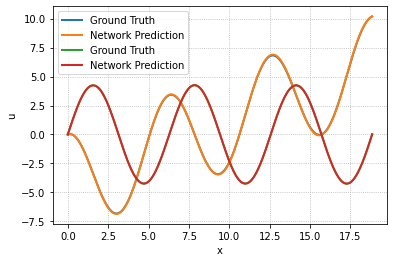

In [7]:
x_test = torch.linspace(0, 6*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")